<a href="https://colab.research.google.com/github/yun-xiaoxiong/yun-xiaoxiong/blob/main/Unet_1_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unet模型复现 
### 姓名： 张宗云
### 时间： 2022年5月

In [ ]:
!pip install SimpleITK
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import SimpleITK as sitk
import os
import glob
import random
import matplotlib.pyplot as plt
torch.cuda.empty_cache()

**设置超参数**

In [ ]:
learning_rate=1e-4
batch_size=1
epoch=50
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

**加载数据集：**其中训练集32个样本，测试集16幅图像

In [ ]:
class Slice_Loader(Dataset):    
    def __init__(self, data_path):        # 初始化函数，读取所有data_path下的图片        
        self.data_path = data_path        
        self.imgs_path_f = glob.glob(os.path.join(data_path, 'img_600/*.nii.gz'))
        self.imgs_path_l = glob.glob(os.path.join(data_path, 'label_600/*.nii.gz'))
    
    def __getitem__(self, index):        # 根据index读取图片        
        image_path_f = self.imgs_path_f[index]
        image_path_l = self.imgs_path_l[index]  
        imagef = sitk.ReadImage(image_path_f)
        imagef_array=sitk.GetArrayFromImage(imagef)
        imagel = sitk.ReadImage(image_path_l)
        imagel_array=sitk.GetArrayFromImage(imagel)
        return imagef_array,imagel_array

        
    def __len__(self):      
        return len(self.imgs_path_l)


dataset = Slice_Loader("/content/")
test_dataset = Slice_Loader("/content/")    
print("训练集数据个数：", len(dataset))
print("测试集数据个数：", len(test_dataset))  
train_loader = DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)

训练集数据个数： 1
测试集数据个数： 1


**定义模型**

In [ ]:
class Unit(nn.Module):
    def __init__(self,ch_in,ch_out,kernel_size=3,stride=1,padding=1):
        super(Unit,self).__init__()
        self.an_unit=nn.Sequential(                         
            nn.Conv2d(ch_in,ch_out,kernel_size=kernel_size,stride=stride,padding=padding),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(),
            nn.Conv2d(ch_out,ch_out,kernel_size=kernel_size,stride=stride,padding=padding),
            nn.BatchNorm2d(ch_out),
            nn.ReLU()
        )
    def forward(self,x):
        return self.an_unit(x)

class Unet(nn.Module):
    def __init__(self):
        super(Unet,self).__init__()
        self.pool=nn.MaxPool2d(2,stride=2)
        self.cr1=Unit(1,64)
        self.cr2=Unit(64,128)
        self.cr3=Unit(128,256)
        self.cr4=Unit(256,512)
        self.cr5=Unit(512,1024)
        
        self.up1=Unit(1024,512)
        self.up2=Unit(512,256)
        self.up3=Unit(256,128)
        self.up4=Unit(128,64)
        
        self.conv=nn.Sequential(
            nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,2,kernel_size=1,stride=1,padding=0)
        )
        
    def forward(self,x):
        x1=self.cr1(x)
        x2=self.cr2(self.pool(x1))
        x3=self.cr3(self.pool(x2))
        x4=self.cr4(self.pool(x3))
        x5=self.cr5(self.pool(x4))
        x5_up=self.up1(nn.functional.interpolate(x5,scale_factor=2))
        # print(x4.shape)
        # print(x5_up.shape)
        x6=self.up1(torch.cat([x4,x5_up],1))
        x6_up=self.up2(nn.functional.interpolate(x6,scale_factor=2))
        x7=self.up2(torch.cat([x3,x6_up],1))
        x7_up=self.up3(nn.functional.interpolate(x7,scale_factor=2))
        x8=self.up3(torch.cat([x2,x7_up],1))
        x8_up=self.up4(nn.functional.interpolate(x8,scale_factor=2))
        x9=self.up4(torch.cat([x1,x8_up],1))
        x10=self.conv(x9)
        return x10

a=torch.randn(1,4,4,4)<br>
b=nn.functional.interpolate(a,64)<br>
b.shape<br>
torch.Size([1, 4, 64, 64])

**训练函数**

In [ ]:
model=Unet()
model=model.cuda()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)
loss_fn=nn.CrossEntropyLoss()

def train():
  model.train()
  for ep in range(epoch):
      for batch_id,(feature,label) in enumerate(train_loader):
          a=[]
          feature=feature.cuda()
          label=label.cuda()
          # feature.shape:  [4, 512, 512]
          out=model(feature.unsqueeze(1)) #[4, 2, 512, 512]
          pred=out.transpose(1,2).transpose(2,3).contiguous().view(-1,2)
          true=label.view(-1).long()
          
          loss=loss_fn(pred,true)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          a.append(loss.item())
      print("epoch:",ep+1,"  loss: ",np.mean(a))
      test()

**计算准确率**

In [ ]:
def test():
    jiao=0
    bing=0
    for batch_id,(feature,label) in enumerate(test_loader):
        # print(feature.shape)  torch.Size([4, 512, 512])
        # print(label.shape)  torch.Size([4, 512, 512])
        model.eval()
        feature=feature.to(device)
        label=label.to(device)
        out=model(feature.unsqueeze(1))
        pred=out.transpose(1,2).transpose(2,3).contiguous().view(-1,2)
        pred=nn.functional.softmax(pred.cpu(),dim=1) # torch.Size([-1,2])- > [-1,2]
        true=label.cpu().view(-1).long()
        
        with torch.no_grad():
          pred=pred[:,1]
          pred[pred >= 0.5] = 1
          pred[pred < 0.5] = 0
  
          jiao+=(true*pred).sum().item()
          bing+=(true+pred).clamp(max=1).sum().item()
          IOU=jiao/bing
          
          plt.imshow(pred.reshape(512,512).numpy()) 
          plt.show()
          plt.imshow(true.reshape(512,512).numpy()) 
          plt.show()
          print("交集：",jiao,"  并集:",bing)
    accuracy=IOU*100
    print("IOU accuracy: ",accuracy,"% ")
    print("----------------------------------------------------------------")
    return IOU

epoch: 1   loss:  0.9175719618797302


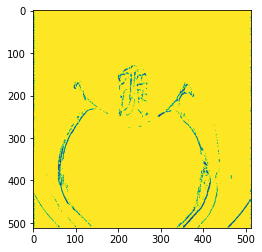

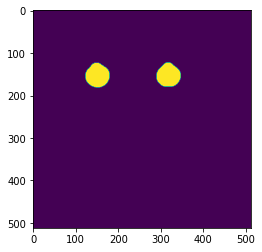

交集： 5012.0   并集: 258603.0
IOU accuracy:  1.938105899776878 % 
----------------------------------------------------------------
epoch: 2   loss:  0.7208225727081299


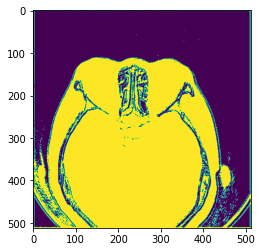

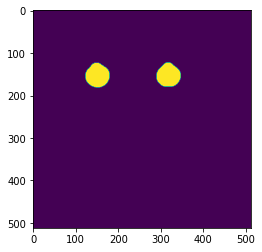

交集： 5012.0   并集: 140088.0
IOU accuracy:  3.5777511278624865 % 
----------------------------------------------------------------
epoch: 3   loss:  0.7049788236618042


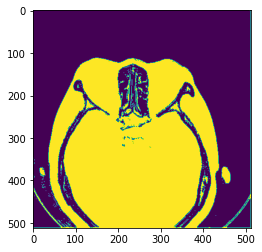

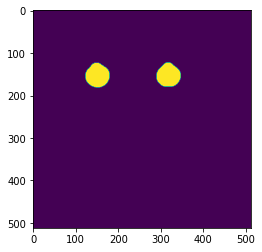

交集： 5012.0   并集: 121884.0
IOU accuracy:  4.112106593154147 % 
----------------------------------------------------------------
epoch: 4   loss:  0.6862156391143799


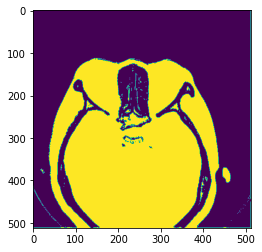

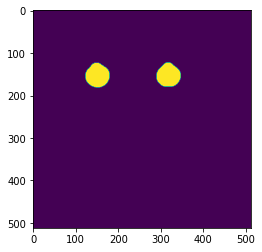

交集： 5012.0   并集: 115868.0
IOU accuracy:  4.325611903200193 % 
----------------------------------------------------------------
epoch: 5   loss:  0.6675131320953369


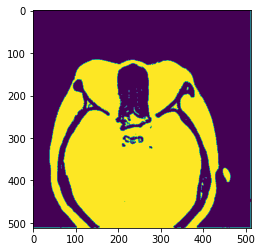

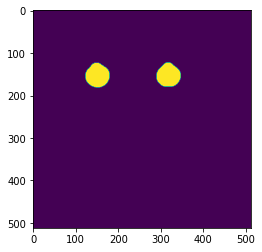

交集： 5012.0   并集: 112194.0
IOU accuracy:  4.467262063924987 % 
----------------------------------------------------------------
epoch: 6   loss:  0.6468479037284851


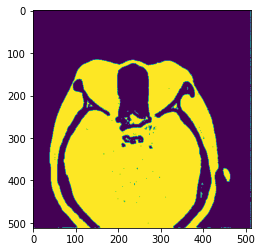

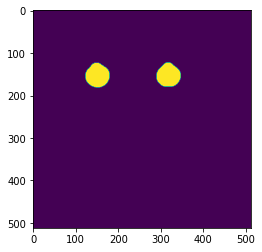

交集： 5012.0   并集: 109441.0
IOU accuracy:  4.579636516479199 % 
----------------------------------------------------------------
epoch: 7   loss:  0.6234105229377747


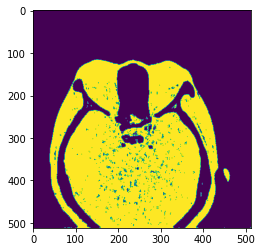

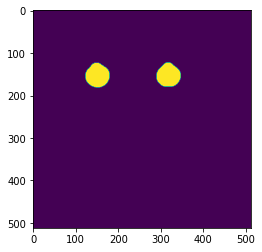

交集： 5008.0   并集: 104488.0
IOU accuracy:  4.7928948778807134 % 
----------------------------------------------------------------
epoch: 8   loss:  0.5978624820709229


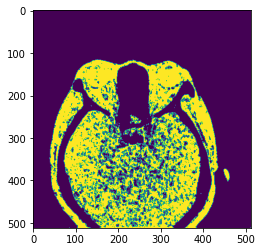

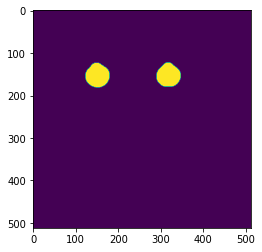

交集： 4858.0   并集: 82243.0
IOU accuracy:  5.906885692399353 % 
----------------------------------------------------------------
epoch: 9   loss:  0.5695726275444031


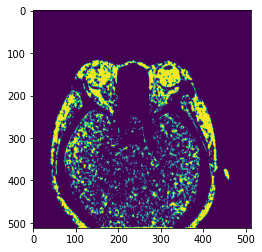

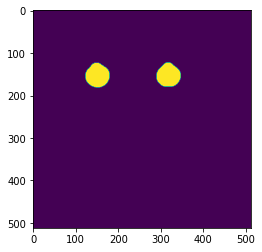

交集： 3995.0   并集: 33238.0
IOU accuracy:  12.019375413683134 % 
----------------------------------------------------------------
epoch: 10   loss:  0.5386651754379272


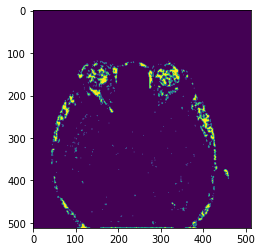

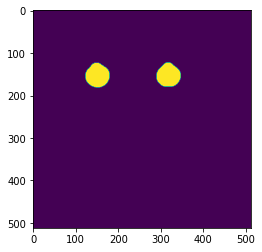

交集： 1937.0   并集: 10413.0
IOU accuracy:  18.60174781523096 % 
----------------------------------------------------------------
epoch: 11   loss:  0.5056573152542114


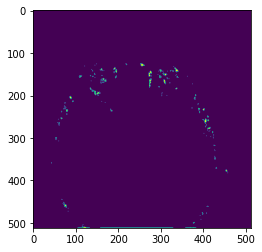

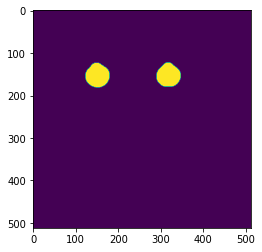

交集： 232.0   并集: 5892.0
IOU accuracy:  3.9375424304141213 % 
----------------------------------------------------------------
epoch: 12   loss:  0.47079887986183167


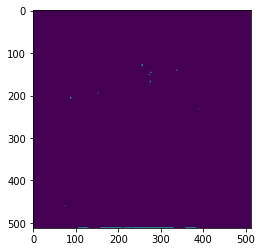

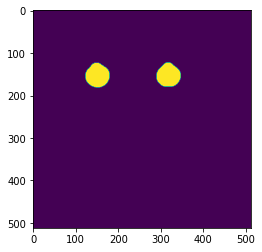

交集： 3.0   并集: 5253.0
IOU accuracy:  0.05711022272986865 % 
----------------------------------------------------------------
epoch: 13   loss:  0.43465203046798706


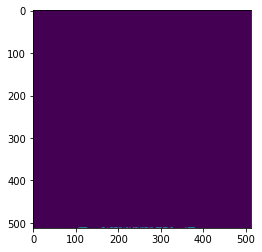

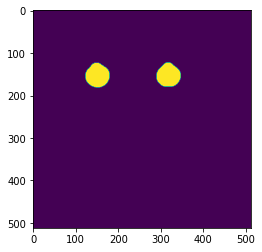

交集： 0.0   并集: 5137.0
IOU accuracy:  0.0 % 
----------------------------------------------------------------
epoch: 14   loss:  0.39810335636138916


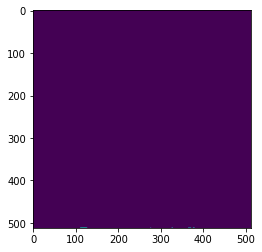

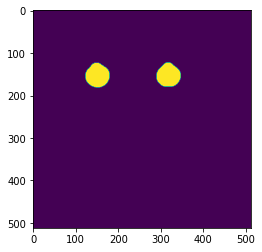

交集： 0.0   并集: 5039.0
IOU accuracy:  0.0 % 
----------------------------------------------------------------
epoch: 15   loss:  0.3622315227985382


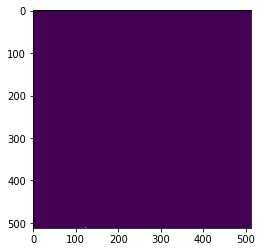

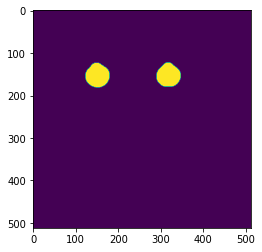

交集： 0.0   并集: 5018.0
IOU accuracy:  0.0 % 
----------------------------------------------------------------
epoch: 16   loss:  0.32799386978149414


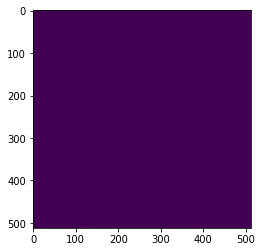

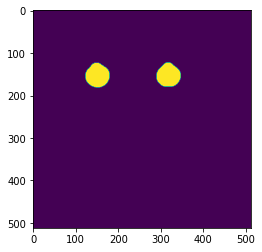

交集： 0.0   并集: 5013.0
IOU accuracy:  0.0 % 
----------------------------------------------------------------
epoch: 17   loss:  0.296594500541687


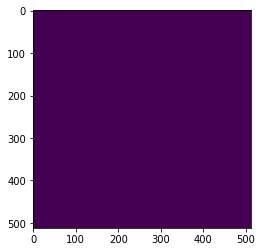

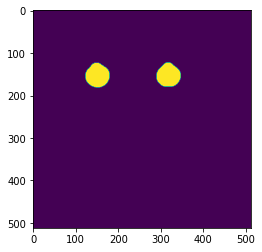

交集： 0.0   并集: 5012.0
IOU accuracy:  0.0 % 
----------------------------------------------------------------
epoch: 18   loss:  0.26794689893722534


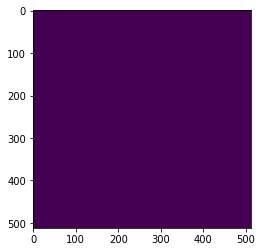

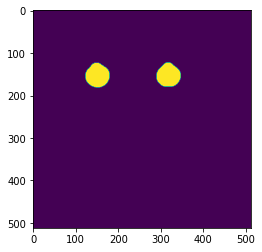

交集： 0.0   并集: 5012.0
IOU accuracy:  0.0 % 
----------------------------------------------------------------


KeyboardInterrupt: ignored

In [ ]:
# torch.cuda.empty_cache()
train()